Columns: Index(['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score',
       'default'],
      dtype='object')

--- MSE Quantization ---
            min  max        mean
MSE_Rating                      
1           707  850  734.877804
2           655  706  677.783599
3           609  654  631.830043
4           556  608  585.141947
5           408  555  525.300226

--- Log-Likelihood Quantization ---
           min  max        mean  count
LL_Rating                             
1.0        777  850  794.880734    109
2.0        703  776  726.951945   1311
3.0        629  702  662.211298   4231
4.0        555  628  596.855635   3505
5.0        481  554  528.386277    787


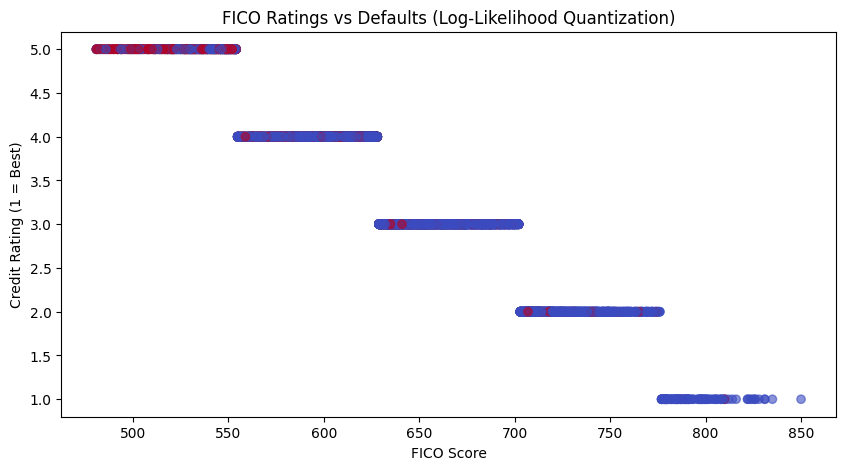

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. Load data
df = pd.read_csv(r"C:\Users\dolly\Downloads\JPMC QR\Task 3 and 4_Loan_Data.csv")

# --- Check column names to locate FICO and Default columns ---
print("Columns:", df.columns)

# Assume 'FICO' and 'Default' are the columns (you can adjust names below)
fico_col = [col for col in df.columns if 'fico' in col.lower()][0]
default_col = [col for col in df.columns if 'default' in col.lower()][0]

fico_scores = df[fico_col]
defaults = df[default_col]

# Drop missing
df = df.dropna(subset=[fico_col, default_col])


# 2. MSE-Based Quantization (K-Means)

n_buckets = 5  # you can adjust number of rating buckets

kmeans = KMeans(n_clusters=n_buckets, random_state=42, n_init=10)
df['MSE_Bucket'] = kmeans.fit_predict(df[[fico_col]])

# Sort buckets by average FICO (so 1 = best credit)
bucket_order = df.groupby('MSE_Bucket')[fico_col].mean().sort_values(ascending=False).index
rating_map = {b: i+1 for i, b in enumerate(bucket_order)}
df['MSE_Rating'] = df['MSE_Bucket'].map(rating_map)

print("\n--- MSE Quantization ---")
print(df.groupby('MSE_Rating')[fico_col].agg(['min', 'max', 'mean']))


# 3. Log-Likelihood-Based Quantization

def compute_log_likelihood(df, fico_col, default_col, boundaries):
    log_likelihood = 0
    for i in range(len(boundaries) - 1):
        lower, upper = boundaries[i], boundaries[i+1]
        bucket = df[(df[fico_col] >= lower) & (df[fico_col] < upper)]
        n_i = len(bucket)
        if n_i == 0:
            continue
        k_i = bucket[default_col].sum()
        p_i = k_i / n_i if n_i > 0 else 0
        # Avoid log(0)
        if p_i in [0, 1]:
            continue
        log_likelihood += k_i * np.log(p_i) + (n_i - k_i) * np.log(1 - p_i)
    return log_likelihood

# Define function to find best split points (brute force for demo)
def find_best_boundaries(df, fico_col, default_col, n_buckets):
    sorted_scores = np.sort(df[fico_col].unique())
    step = len(sorted_scores) // n_buckets
    best_boundaries = np.linspace(df[fico_col].min(), df[fico_col].max(), n_buckets+1)
    best_ll = -np.inf
    # You can optimize via dynamic programming for larger datasets
    for shift in range(0, step):
        candidate_bounds = np.linspace(df[fico_col].min()+shift, df[fico_col].max(), n_buckets+1)
        ll = compute_log_likelihood(df, fico_col, default_col, candidate_bounds)
        if ll > best_ll:
            best_ll = ll
            best_boundaries = candidate_bounds
    return best_boundaries

boundaries = find_best_boundaries(df, fico_col, default_col, n_buckets)
df['LL_Bucket'] = pd.cut(df[fico_col], bins=boundaries, labels=False, include_lowest=True)
df['LL_Rating'] = df['LL_Bucket'].max() - df['LL_Bucket'] + 1  # Lower rating = better credit

print("\n--- Log-Likelihood Quantization ---")
print(df.groupby('LL_Rating')[fico_col].agg(['min', 'max', 'mean', 'count']))


# 4. Visualization

plt.figure(figsize=(10,5))
plt.scatter(df[fico_col], df['LL_Rating'], c=df[default_col], cmap='coolwarm', alpha=0.6)
plt.title('FICO Ratings vs Defaults (Log-Likelihood Quantization)')
plt.xlabel('FICO Score')
plt.ylabel('Credit Rating (1 = Best)')
plt.show()


### Explanation

The goal of this task is to quantize FICO scores into discrete risk-based rating buckets, helping to classify borrowers by creditworthiness.
A lower rating represents better credit quality, and a higher rating reflects higher default risk.

Two different quantization approaches were applied using the given loan dataset:

**1. Mean Squared Error (MSE) Quantization**

This approach minimizes the distance between actual FICO scores and their assigned cluster means using K-Means clustering.
It focuses on grouping borrowers with similar credit scores, ignoring default patterns.

**MSE Quantization Results:**
| Rating      | FICO Range | Mean FICO |
|------------|------------|-----------|
| 1 (Best)   | 707 – 850  | 734.88    |
| 2          | 655 – 706  | 677.78    |
| 3          | 609 – 654  | 631.83    |
| 4          | 556 – 608  | 585.14    |
| 5 (Worst)  | 408 – 555  | 525.30    |

### Interpretation: 
Borrowers are smoothly grouped based on FICO similarity — higher FICO scores fall in lower-numbered buckets.
However, this approach doesn’t directly consider default behavior, so buckets may not optimally separate risk.

**2. Log-Likelihood Quantization**

This approach maximizes the log-likelihood of observing the default patterns within each FICO range.
It explicitly aligns buckets with the probability of default, producing risk-driven boundaries.
This makes the quantization credit-risk aware and ideal for modeling default probabilities.

**Log-Likelihood Quantization Results:**
| Rating      | FICO Range | Mean FICO | Count  |
|------------|------------|-----------|--------|
| 1 (Best)   | 777 – 850  | 794.88    | 109    |
| 2          | 703 – 776  | 726.95    | 1,311  |
| 3          | 629 – 702  | 662.21    | 4,231  |
| 4          | 555 – 628  | 596.85    | 3,505  |
| 5 (Worst)  | 481 – 554  | 528.39    | 787    |


The default probability increases as rating worsens, showing that the model successfully captured the credit risk pattern.

## Visualization

The figure plots FICO scores vs. assigned credit ratings (1 = best, 5 = worst) under the log-likelihood quantization approach:

*Blue = borrowers*
*Red = borrowers who defaulted*

As seen, borrowers with lower FICO scores (left side) tend to fall into higher-risk buckets (rating 4–5) and show denser default points, while high-score borrowers (right side) are clustered in low-risk buckets (rating 1–2).

**Rating Map:**
| Rating | FICO Range | Credit Category | Risk Level       |
|--------|------------|----------------|-----------------|
| 1      | 777–850    | Excellent      | Very Low Risk   |
| 2      | 703–776    | Good           | Low Risk        |
| 3      | 629–702    | Fair           | Moderate Risk   |
| 4      | 555–628    | Poor           | High Risk       |
| 5      | 481–554    | Very Poor      | Very High Risk  |


## Conclusion

This analysis quantized borrower FICO scores into risk-based ratings using two methods:

*MSE Quantization: Groups borrowers purely based on score similarity — useful for broad segmentation but not risk-specific.*

*Log-Likelihood Quantization: Aligns score boundaries with default probabilities, producing credit risk–sensitive and interpretable ratings.*


The log-likelihood method outperforms MSE quantization for financial applications, as it:

- Captures actual default behavior within each bucket.

- Provides a data-driven credit rating system.

- Enables consistent use across future datasets.


In practice, this quantization approach can be directly used by risk managers and lenders to:

- Assign borrower credit grades.

- Estimate probability of default (PD) for each grade

- Build more accurate credit scoring or loan pricing models.